In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import pyam
import pandas as pd
import sys
sys.path.append('/Users/stuartjenkins/Documents/$$Work/2019:02:01 - Carbon budgets with CO2-fe paper')
from fair_scm import *


# from scipy.stats import lognorm
# from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.ndimage.filters import gaussian_filter

from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [2]:
# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
co2_ems_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx', encoding='utf-8')
co2_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx', encoding='utf-8')
total_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_lower_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx', encoding='utf-8')
two_lower_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx', encoding='utf-8')
two_lower_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_higher_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx', encoding='utf-8')
two_higher_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx', encoding='utf-8')
two_higher_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx', encoding='utf-8')

# import RCP85 scenario to stitch onto past
RCP85_E = pd.read_csv('../RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_RF = pd.read_csv('../RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP3_E = pd.read_csv('../RCP_data/RCP3PD_EMISSIONS.csv',skiprows=36,index_col=0)
RCP3_RF = pd.read_csv('../RCP_data/RCP3PD_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP45_E = pd.read_csv('../RCP_data/RCP45_EMISSIONS.csv',skiprows=36,index_col=0)
RCP45_RF = pd.read_csv('../RCP_data/RCP45_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP6_E = pd.read_csv('../RCP_data/RCP6_EMISSIONS.csv',skiprows=36,index_col=0)
RCP6_RF = pd.read_csv('../RCP_data/RCP6_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx`


TCR:  1.6 K
ECS:  2.75 K
calculated TCRE:  1.320509133357194 K/TtC
AGWP_CO2 for pulse emissions:  1187.895949642086
AGWP_CO2 for const emissions:  1139.9403307941259


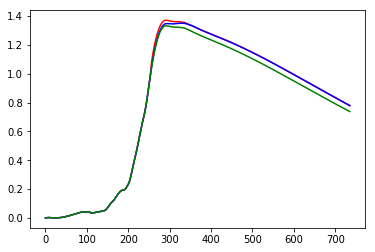

In [3]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2018
non_co2_forcing_average_over = 10

fbar_s = np.array([])
f0_s = np.array([])
f1_s = np.array([])
delta_fs = np.array([])

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.6
ECS_val = 2.75
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])
gamma = (1 - np.exp(-epsilon*H))/(epsilon*H)

# magicc like AGWP value
r0 = 32.4 # 33.6
rC = 0.019 # 0.0206
rT = 4.165 # 4.635

base_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems[year_val-1765] += 100. * 12 / 44

other_rf = RCP3_RF.TOTAL_ANTHRO_RF.values - RCP3_RF.CO2_RF.values

C_pulse, T_pulse = fair_scm(emissions=pulse_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)
C_base, T_base = fair_scm(emissions=base_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)

RF_net = (F_2x * np.log(C_pulse / C_0) / np.log(2.0)) - (F_2x * np.log(C_base / C_0) / np.log(2.0))
AGWP_CO2 = sp.integrate.simps(RF_net[year_val-1765:year_val+101-1765]) / 100
TCRE = (((H / AGWP_CO2) * (F_2x / TCR_val)) * (12 / 44000))**-1
print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')
print('AGWP_CO2 for pulse emissions: ',H/AGWP_CO2)

const_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
const_ems[year_val-1765:year_val+101-1765] += (12/44)

C_const, T_const = fair_scm(emissions=const_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)
RF_net_const = (F_2x * np.log(C_const / C_0) / np.log(2.0)) - (F_2x * np.log(C_base / C_0) / np.log(2.0))
AGWP_CO2_const = RF_net_const[year_val+100-1765]

plt.plot(T_pulse, color='red')
plt.plot(T_const, color='blue')
plt.plot(T_base, color='green')

print('AGWP_CO2 for const emissions: ', H/AGWP_CO2_const)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


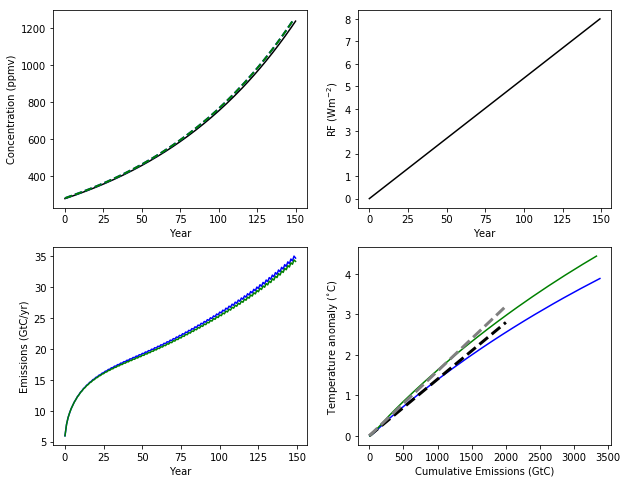

In [7]:
# should we diagnose the AGWP in 2 ways

# i.e. using hte methodology we have specified already here 

# 1) pulse emissions of CO2 over background state, integrate effect of pulse on RF over 100years

# 2) 1/100th of the pulse 

fig, ax = plt.subplots(2,2, figsize=(10,8))

C_0 = 278.0

t = np.arange(0,151)

C1 = C_0*1.01**t

ax[0,0].plot(t,C1, color='black')
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Concentration (ppmv)')

ax[0,1].plot(t[:-1], F_2x*np.log(C1[:-1]/C_0)/np.log(2.0), color='black')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('RF (Wm$^{-2}$)')

TCR_val = 1.6
ECS_val = 2.75
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
r0 = 32.4
rC = 0.019
rT = 4.165

T_back, E_back = fair_scm_emsback(F_2x*np.log(C1/C_0)/np.log(2.0), TCR=TCR_val, ECS=ECS_val, r0=r0, rC=rC, rT=rT, d1=d_array[0], d2=d_array[1])   

C, T = fair_scm(emissions=E_back, tcrecs=np.array([TCR_val,ECS_val]), r0=r0, rC=rC, rT=rT, d=d_array, F_2x=F_2x)

ax[1,0].plot(t[:-1], E_back[:-1], color='blue')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Emissions (GtC/yr)')

ax[1,1].plot(np.cumsum(E_back[:-1]), T[:-1], color='blue')

ax[1,1].plot(np.arange(0,2001,10), np.arange(0,2001,10)*0.001*1.4, color='black', linestyle='--', linewidth=3)

ax[1,1].set_xlabel('Cumulative Emissions (GtC)')
ax[1,1].set_ylabel('Temperature anomaly ($^{\circ}$C)')

ax[0,0].plot(t[:-1], C[:-1], color='blue', linestyle='--', linewidth=2)


TCR_val = 1.85
ECS_val = 3.0
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
r0 = 32.4
rC = 0.019
rT = 4.165

T_back, E_back = fair_scm_emsback(F_2x*np.log(C1/C_0)/np.log(2.0), TCR=TCR_val, ECS=ECS_val, r0=r0, rC=rC, rT=rT, d1=d_array[0], d2=d_array[1])   

C, T = fair_scm(emissions=E_back, tcrecs=np.array([TCR_val,ECS_val]), r0=r0, rC=rC, rT=rT, d=d_array, F_2x=F_2x)

ax[1,0].plot(t[:-1], E_back[:-1], color='green')
ax[1,1].plot(np.cumsum(E_back[:-1]), T[:-1], color='green')
ax[0,0].plot(t[:-1], C[:-1], color='green', linestyle='--', linewidth=2)
ax[1,1].plot(np.arange(0,2001,10), np.arange(0,2001,10)*0.001*1.6, color='grey', linestyle='--', linewidth=3)


(-0.75, 10)

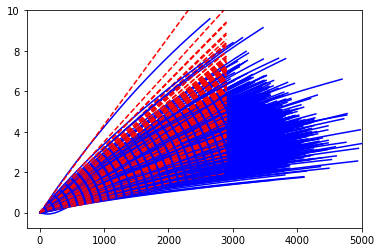

In [97]:
# -------------------
num = 1000
RWF_vals = np.random.normal(0.6,0.0915,num)
TCR_vals = np.ones(num) * np.random.lognormal(0.458, 0.279, num)
ECS_vals = TCR_vals/RWF_vals

d_vals = np.ones((2,num))
d_vals[0,:] = np.random.normal(239,63,num)
d_vals[1,:] = np.random.lognormal(1.2998, 0.506, num)

r_vals = np.zeros((3,num))
beta = np.random.normal(0.7, 0.19, num)
gamma = np.random.normal(1.07, 0.1, num)
r_vals[0,:] = gamma*32.4
r_vals[1,:] = gamma*beta*0.019
r_vals[2,:] = gamma*beta*4.165
# -------------------

def tcre_to_fit(E_in, tcre_param):
    return tcre_param*np.cumsum(E_in)*0.001

TCRE_vals = np.zeros((3,num))

for i in range(0,num):
    T_back, E_back = fair_scm_emsback(F_2x*np.log(C1/C_0)/np.log(2.0), TCR=TCR_vals[i], ECS=ECS_vals[i], r0=r_vals[0,i], rC=r_vals[1,i], rT=r_vals[2,i], d1=d_vals[0,i], d2=d_vals[1,i])   

    C, T = fair_scm(emissions=E_back, tcrecs=np.array([TCR_vals[i],ECS_vals[i]]), r0=r_vals[0,i], rC=r_vals[1,i], rT=r_vals[2,i], d=d_vals[:,i], F_2x=F_2x)
    
    popt, popc = curve_fit(tcre_to_fit, E_back[:np.abs(np.cumsum(E_back[:-1]) - 1000.).argmin() + 1], T[:np.abs(np.cumsum(E_back[:-1]) - 1000.).argmin() + 1])

    TCRE_vals[:,i] = [popt[0], TCR_vals[i], ECS_vals[i]]
    
    plt.plot(np.cumsum(E_back)[:-1], T[:-1], color='blue')
    plt.plot(np.arange(0,3000,100), popt[0]*0.001*np.arange(0,3000,100), color='red', linestyle='--')
    
plt.xlim(-200,5000)
plt.ylim(-0.75,10)

1.7010064644390042 1.9 3.25


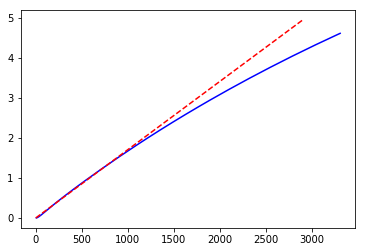

In [9]:
# h = plt.hist(TCRE_vals[0,:], bins = 40)
# print(np.percentile(TCRE_vals[0,:], 67))

# plt.figure()
# h = plt.hist(TCRE_vals[1,:], bins = 40)
# print(np.percentile(TCRE_vals[1,:], 67))

# plt.figure()
# h = plt.hist(TCRE_vals[2,:], bins = 40)
# print(np.percentile(TCRE_vals[2,:], 67))

def tcre_to_fit(E_in, tcre_param):
    return tcre_param*np.cumsum(E_in)*0.001

T_back, E_back = fair_scm_emsback(F_2x*np.log(C1/C_0)/np.log(2.0), TCR=1.9, ECS=3.35, r0=32.4, rC=0.019, rT=4.165, d1=239.0, d2=4.1)   

C, T = fair_scm(emissions=E_back, tcrecs=np.array([1.9,3.25]), r0=32.4, rC=0.019, rT=4.165, d=np.array([239.0,4.1]), F_2x=F_2x)
    
popt, popc = curve_fit(tcre_to_fit, E_back[:np.abs(np.cumsum(E_back[:-1]) - 1000.).argmin() + 1], T[:np.abs(np.cumsum(E_back[:-1]) - 1000.).argmin() + 1])

print(popt[0], 1.9, 3.25)

plt.figure()
plt.plot(np.cumsum(E_back)[:-1], T[:-1], color='blue')
plt.plot(np.arange(0,3000,100), popt[0]*0.001*np.arange(0,3000,100), color='red', linestyle='--')

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


(-0.1, 1.0)

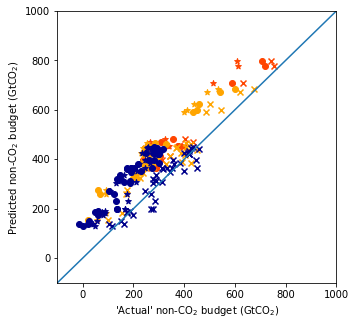

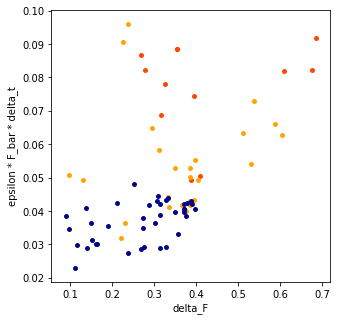

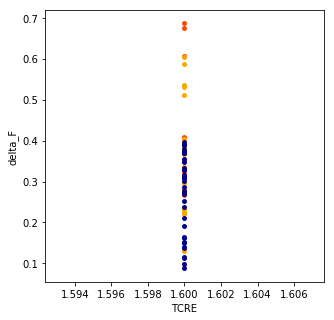

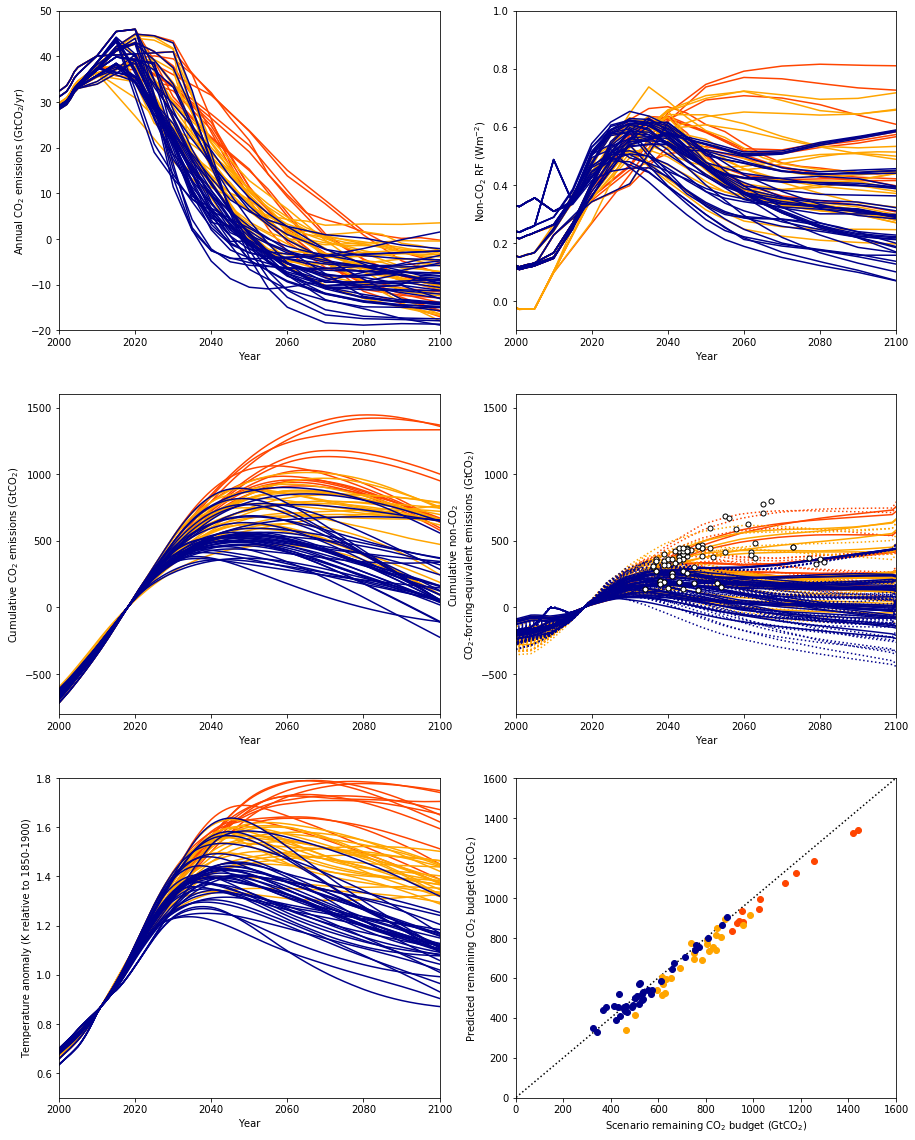

In [4]:
TCR_val=1.8 
ECS_val=3.0


k = 0

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$)')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(3,2,figsize=(15,20))
ax[0,0].set_xlim(2000,2100)
ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[2,0].set_xlim(2000,2100)
ax[2,1].set_xlim(0,1600)
ax[2,1].set_ylim(0,1600)
ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Cumulative CO$_2$ emissions (GtCO$_2$)')
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Cumulative non-CO$_2$ \nCO$_2$-forcing-equivalent emissions (GtCO$_2$)')
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Temperature anomaly (K relative to 1850-1900)')
ax[2,1].set_xlabel('Scenario remaining CO$_2$ budget (GtCO$_2$)')
ax[2,1].set_ylabel('Predicted remaining CO$_2$ budget (GtCO$_2$)')

TCRE = 1.6
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val



for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='orangered')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')

                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='orange')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   

                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
    for i in range(0,len(list(co2_ems_df.models()))):
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
            k += 1
            print(k)
            
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='darkblue')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)
                delta_fs = np.append(delta_fs, F_1 - F_0)

# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax[2,0].set_ylim(0.5,1.8)
ax[1,1].set_ylim(-800,1600)
ax[1,0].set_ylim(-800,1600)
ax[0,0].set_ylim(-20,50)
ax[0,1].set_ylim(-0.1,1.0)





invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


1.3845303681741994
105.83
1.3741651106713664
130.52
1.3879470113370438
136.43
1.468660572005529
217.68
1.4180974943665048
157.54
1.41719917237746
185.25
1.4176633540023809
198.61
1.3907085278239344
145.64
1.4543010841261335
184.67
1.4396654723285234
183.43
1.423989692595372
188.67
1.3707329871610887
151.94
1.4550653203259005
244.62
1.6247233214043975
259.31
1.471131630624826
285.18
1.484176987035347
288.51
1.47068438941884
284.81
1.4501735065084678
283.25
1.4908885247657915
248.10
1.5495439833209828
254.30
1.4517457376493628
243.32
1.6669696601957678
265.55
1.5117394949247012
229.39
1.6105996885112694
240.88
1.5915161036327772
246.84
1.4184343813402598
212.83
1.3783302161080662
86.25
1.268270749229382
35.81
1.2833231084377617
74.03
1.3498847583365106
54.14
1.334780195715257
76.26
1.3589337488996525
29.92
1.4573759505272141
40.88
1.4569280136758709
81.91


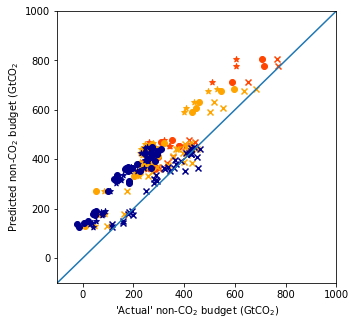

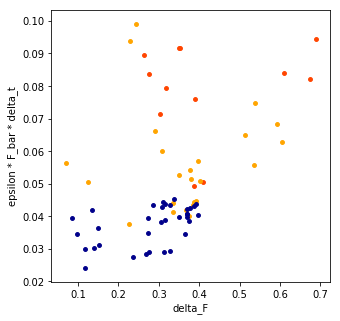

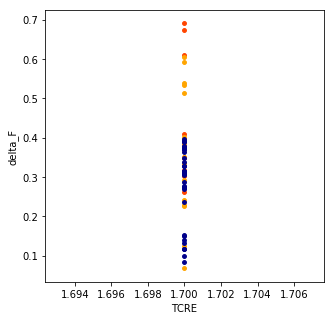

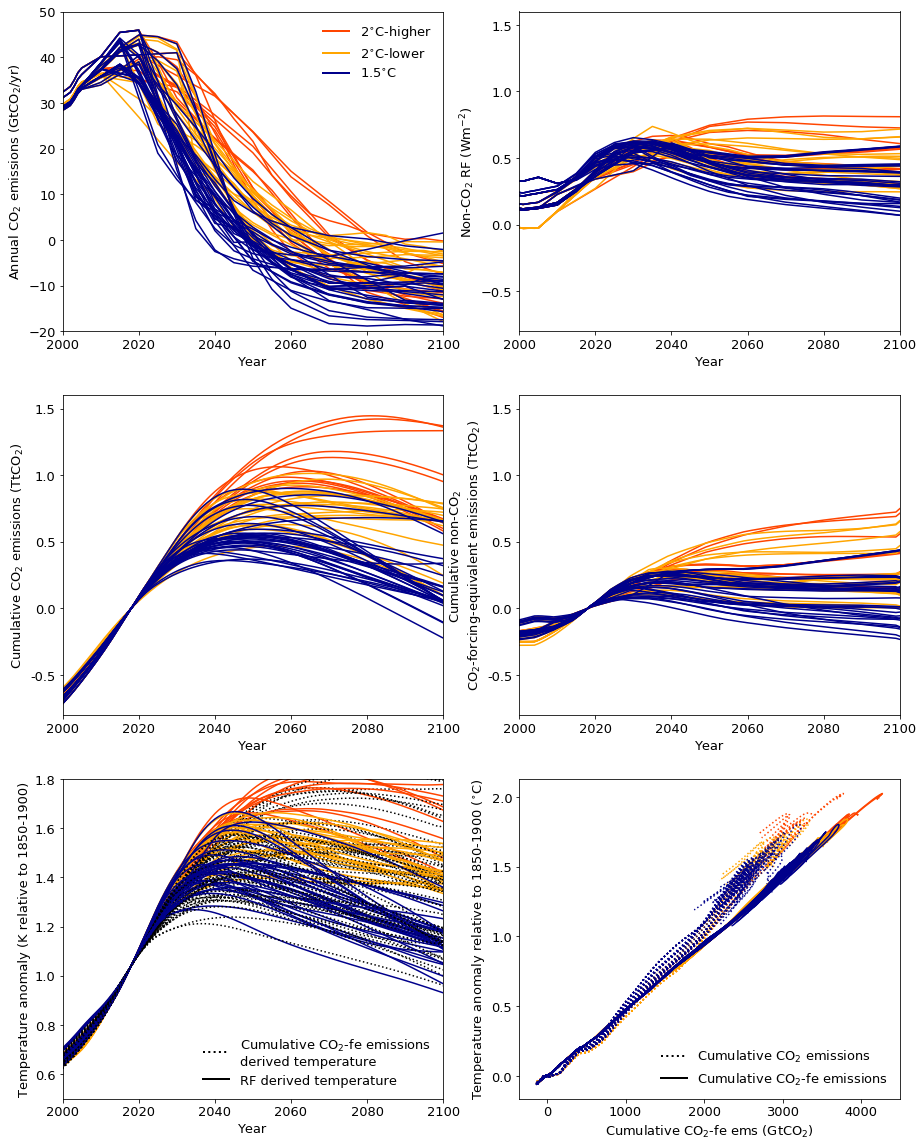

In [7]:
TCR_val = 1.90
ECS_val = 3.25




fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(3,2,figsize=(15,20))
ax[0,0].set_xlim(2000,2100)
ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[2,0].set_xlim(2000,2100)
# ax[2,1].set_xlim(0,1600)
# ax[2,1].set_ylim(0,1600)
# ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ftsize = 13

ax[0,0].set_xlabel('Year', fontsize=ftsize)
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)', fontsize=ftsize)
ax[0,1].set_xlabel('Year', fontsize=ftsize)
ax[0,1].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)', fontsize=ftsize)
ax[1,0].set_xlabel('Year', fontsize=ftsize)
ax[1,0].set_ylabel('Cumulative CO$_2$ emissions (TtCO$_2$)', fontsize=ftsize)
ax[1,0].set_yticklabels([-1.0,-0.5,0.0,0.5,1.0,1.5])
ax[1,1].set_xlabel('Year', fontsize=ftsize)
ax[1,1].set_ylabel('Cumulative non-CO$_2$ \nCO$_2$-forcing-equivalent emissions (TtCO$_2$)', fontsize=ftsize)
ax[1,1].set_yticklabels([-1.0,-0.5,0.0,0.5,1.0,1.5])
ax[2,0].set_xlabel('Year', fontsize=ftsize)
ax[2,0].set_ylabel('Temperature anomaly (K relative to 1850-1900)', fontsize=ftsize)
ax[2,1].set_xlabel('Cumulative CO$_2$-fe ems (GtCO$_2$)', fontsize=ftsize)
ax[2,1].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=ftsize)

# ax[0,0].set_yticks([-20,-10,0,10,20,30,40,50,60])

ax[0,0].tick_params(labelsize=ftsize)
ax[1,0].tick_params(labelsize=ftsize)
ax[2,0].tick_params(labelsize=ftsize)
ax[0,1].tick_params(labelsize=ftsize)
ax[1,1].tick_params(labelsize=ftsize)
ax[2,1].tick_params(labelsize=ftsize)

TCRE = 1.7
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val


for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orangered')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orange')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
#     for i in range(0,len(list(co2_ems_df.models()))):
    for i in [0,1,3,4,5,6,7]:
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
#             print('i, j: ', i, ', ', j)
            
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                
#                 print(single_nonco2rf.values)
                
                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='darkblue')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue',linestyle=':')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                #ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                #ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)

                delta_fs = np.append(delta_fs, F_1 - F_0)
        
#                 print("%.2f" % round((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765])*44/12,2))
                print(np.max(T_run - T_run[2018-1765] + 1.04))
                print("%.2f" % round((np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765])*44/12,2))
    
ax[2,0].set_ylim(0.5,1.8)
ax[1,1].set_ylim(-800,1600)
ax[1,0].set_ylim(-800,1600)
ax[0,0].set_ylim(-20,50)
ax[0,1].set_ylim(-0.8,1.6)

legend_elements = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$-fe emissions \nderived temperature'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='RF derived temperature')]
ax[2,0].legend(handles=legend_elements, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

legend_elements2 = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$ emissions'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions')]
ax[2,1].legend(handles=legend_elements2, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

legend_elements3 = [Line2D([0], [0], color='orangered', lw=2, linestyle='-', label='2$^{\circ}$C-higher'),
                   Line2D([0], [0], color='orange', lw=2, linestyle='-', label='2$^{\circ}$C-lower'),
                   Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='1.5$^{\circ}$C')]
ax[0,0].legend(handles=legend_elements3, loc='upper right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

ax[0,0].grid(False)

# fig.savefig('Figure1.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
linewidths is ignored by contourf


131.7788000000001
279.9223
538.8182
780.3726


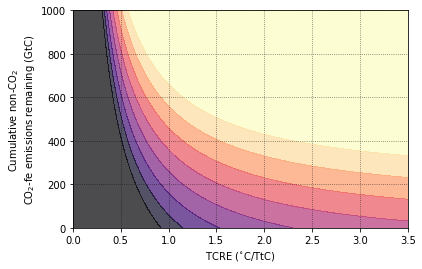

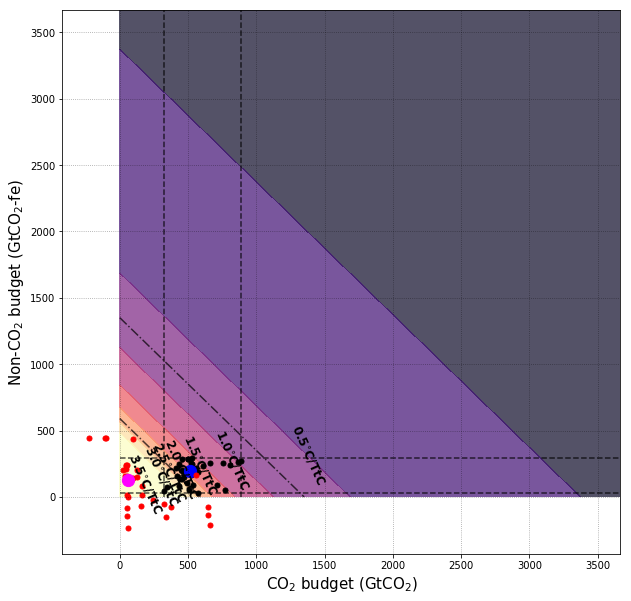

In [130]:
CO2_2100 = np.array([158.55, 245.90, 320.86, 124.02, 164.38, 20.30, 45.69, 163.84, 373.11, 98.39, 38.43, 340.15, 128.47, 560.11, -108.34, 94.78, -103.48, -222.57, 648.56, 648.44, 657.57, 52.55, 52.89, 60.44, 57.97, 50.89, 56.61, 57.25, 56.04, 61.27, 54.64, 47.14, 49.66, 46.77])
non_CO2_2100 = np.array([-71.87, -26.54, -54.67, 202.37, 80.72, 200.38, 208.18, 13.66, -74.89, 139.12, 158.95, -154.25, 150.80, 165.60, 443.32, 436.95, 443.31, 441.98, -137.33, -74.87, -208.96, -86.65, -142.07, -3.66, -232.37, 11.90, 121.64, 124.76, 125.00, 138.74, 155.51, 238.06, 241.27, 229.95])      

print(np.percentile(np.sort(CO2_2100), 67))
print(np.percentile(np.sort(CO2_2100+non_CO2_2100), 67))

CO2_peak = np.array([493.42,439.52,458.24,557.17,519.96,464.71,455.78,469.96,571.53,536.55,488.15,422.55,531.89,866.98,502.02,530.29,501.06,456.73,520.17,658.87,433.71,889.19,611.94,809.66,754.72,412.14,535.16,324.59,342.32,508.76,430.83,573.46,773.19,711.89])
non_CO2_peak = np.array([107.49,132.40,138.38,220.41,163.26,189.73,201.16,151.70,187.23,185.94,193.30,154.05,247.42,264.57,288.28,291.68,287.91,286.32,251.98,257.46,246.03,268.86,232.28,243.94,254.51,215.30,87.80,41.95,75.41,55.33,81.22,30.99,48.27,88.85])

print(np.percentile(np.sort(CO2_peak), 67))
print(np.percentile(np.sort(CO2_peak+non_CO2_peak), 67))

# −175 to 475 GtCO2 (SSP2 median: 250 GtCO2, rounded to the nearest 25 GtCO2)
# ~350 GtCO2 for 2018-2100 budget

# attempt at new figure 4
n = 100

TCRE_values = np.random.lognormal(0.348, 0.289, n)

total_ems_remaining = (1.5-1.04)*1000/TCRE_values
nonCO2_co2fe_ems = np.arange(0,1000,100)

TCREs, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,3.5,100), np.linspace(0,1000,100))

CO2_budgets = (1.5-1.04)*1000/TCREs - nonCO2_co2fe_budgets

plt.contourf(TCREs, nonCO2_co2fe_budgets, CO2_budgets, [-200,-100,0,100,200,300,400,500], extend='both', cmap=plt.cm.magma.reversed(), alpha=0.7, linewidths=0.0)
plt.grid(True, linestyle=':', color='black', alpha = 0.6)
plt.xlabel('TCRE ($^{\circ}$C/TtC)')
plt.ylabel('Cumulative non-CO$_2$ \nCO$_2$-fe emissions remaining (GtC)')

scen_nonCO2_budgets = non_CO2_peak
scen_total_budgets = non_CO2_peak + CO2_peak
scen_co2_budgets = np.array(scen_total_budgets) - np.array(scen_nonCO2_budgets)

CO2_budgets, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,1000,100), np.linspace(0.001,1000,100))
TCREs = (1.5-1.04)*1000/(CO2_budgets + nonCO2_co2fe_budgets)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(scen_co2_budgets, scen_nonCO2_budgets, color='black', s=25)
plt.scatter(np.median(scen_co2_budgets), np.median(scen_nonCO2_budgets), color='blue', s=150)

nonCO2_21st_century = non_CO2_2100
CO2_21st_century = CO2_2100
plt.scatter(CO2_21st_century, nonCO2_21st_century, s=25, color='red')
plt.scatter(np.median(CO2_21st_century), np.median(nonCO2_21st_century), color='magenta', s=150)

plt.contourf(CO2_budgets*44/12, nonCO2_co2fe_budgets*44/12, TCREs, [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5], cmap=plt.cm.magma, alpha=0.7, linewidths=0.0, zorder=-100, extend='both')
# plt.xlim(0,1400)
# plt.ylim(0,500)
plt.grid(True, color='black', linestyle=':', alpha=0.4)
# plt.text(335,130,'0.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(185,120,'1.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(120,110,'1.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(83,100,'2.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(60,90,'2.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(45,80,'3.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(10,70,'3.5$^{\circ}$C/TtC', color='black', fontsize=12)

plt.annotate('0.5$^{\circ}$C/TtC',xy=(335*44/12,130*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.0$^{\circ}$C/TtC',xy=(185*44/12,120*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.5$^{\circ}$C/TtC',xy=(120*44/12,110*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.0$^{\circ}$C/TtC',xy=(83*44/12,102*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.5$^{\circ}$C/TtC',xy=(58*44/12,95*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.0$^{\circ}$C/TtC',xy=(42*44/12,87*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.5$^{\circ}$C/TtC',xy=(10*44/12,70*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')

ax.plot([np.min(scen_co2_budgets), np.min(scen_co2_budgets)],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
ax.plot([np.max(scen_co2_budgets), np.max(scen_co2_budgets)],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000*44/12],[np.min(scen_nonCO2_budgets), np.min(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000*44/12],[np.max(scen_nonCO2_budgets), np.max(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)

ax.plot([0,(155 + ((185-155)/5))*44/12],[(155 + ((185-155)*1/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

ax.plot([0,(307 + ((460-307)*2/5))*44/12],[(307 + ((460-307)*2/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

# ax.set_xticklabels([0,100,200,300,400,500,600], fontsize=15)
# ax.set_yticklabels([0,20,40,60,80,100,120,140], fontsize=15)
ax.set_xlabel('CO$_2$ budget (GtCO$_2$)', fontsize=15)
ax.set_ylabel('Non-CO$_2$ budget (GtCO$_2$-fe)', fontsize=15)
plt.show()

# fig.savefig('Figure4.pdf', dpi=300)


59.205 129.635
-222.57 -232.62
657.57 451.42
: 234.76
-174.65
730.35
150.03764705882355 98.1894117647059


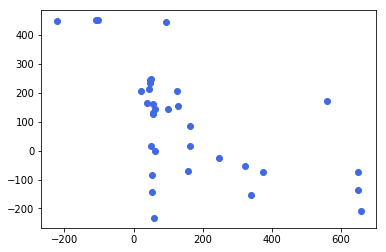

In [7]:
CO2_21st_century = np.array([158.55, 245.90, 320.86, 124.02, 164.38, 20.30, 45.69, 163.84, 373.11, 98.39, 38.43, 340.15, 128.47, 560.11, -108.34, 94.78, -103.48, -222.57, 46.77, 49.66, 47.14, 54.64, 61.27, 56.04, 57.25, 56.61, 50.89, 57.97, 60.44, 52.89, 52.55, 657.57, 648.56, 648.44])   
nonCO2_21st_century = np.array([-70.46, -24.24, -52.66, 207.95, 84.66, 205.61, 213.51, 16.62, -72.90, 143.80, 163.92, -153.27, 155.02, 170.24, 451.42, 445.23, 451.41, 449.90, 235.84, 247.57, 243.87, 160.75, 143.55, 129.75, 129.52, 125.94, 14.74, -232.62, -1.00, -141.31, -85.14, -209.08, -136.56, -73.14])   

plt.scatter(CO2_21st_century, nonCO2_21st_century, color='royalblue')

print(np.median(CO2_21st_century), np.median(nonCO2_21st_century))
print(np.min(CO2_21st_century), np.min(nonCO2_21st_century))
print(np.max(CO2_21st_century), np.max(nonCO2_21st_century))

print(':', np.median(CO2_21st_century+nonCO2_21st_century))
print(np.min(CO2_21st_century+nonCO2_21st_century))
print(np.max(CO2_21st_century+nonCO2_21st_century))

print(np.mean(CO2_21st_century), np.mean(nonCO2_21st_century))

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
linewidths is ignored by contourf


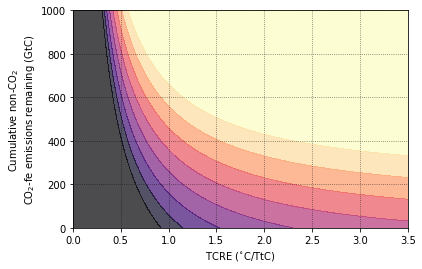

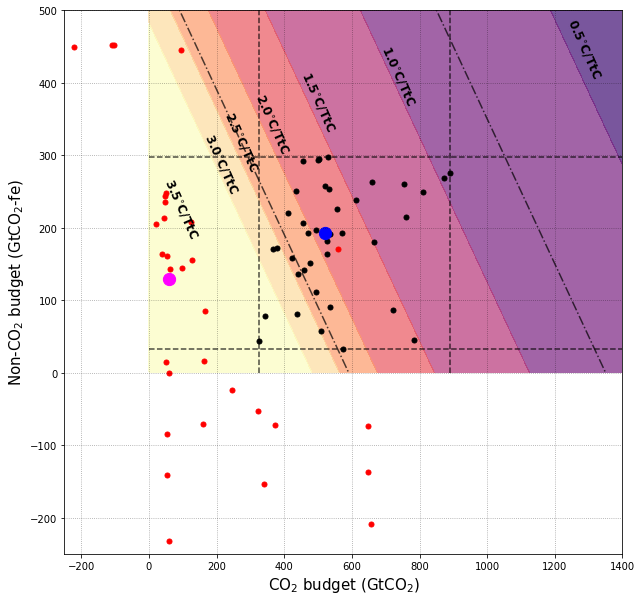

In [8]:
# attempt at new figure 4
n = 100

TCRE_values = np.random.lognormal(0.348, 0.289, n)

total_ems_remaining = (1.5-1.04)*1000/TCRE_values
nonCO2_co2fe_ems = np.arange(0,1000,100)

TCREs, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,3.5,100), np.linspace(0,1000,100))

CO2_budgets = (1.5-1.04)*1000/TCREs - nonCO2_co2fe_budgets

plt.contourf(TCREs, nonCO2_co2fe_budgets, CO2_budgets, [-200,-100,0,100,200,300,400,500], extend='both', cmap=plt.cm.magma.reversed(), alpha=0.7, linewidths=0.0)
plt.grid(True, linestyle=':', color='black', alpha = 0.6)
plt.xlabel('TCRE ($^{\circ}$C/TtC)')
plt.ylabel('Cumulative non-CO$_2$ \nCO$_2$-fe emissions remaining (GtC)')

scen_nonCO2_budgets = [30.172772089960304,37.086188616933086,38.75206042029008,58.48751643383132,49.09180478019327,46.83576290905759,49.46672988296113,46.437475666071904,61.51180104779496,44.78598647597546,52.44669228143334,56.17159093073873,41.42193608215727,52.365409932673074,51.993083992512325,53.47437004150561,43.092123955406706,68.90836925290158,73.17431813677867,80.1952095826671,81.15674362561651,80.09341906460025,79.64223386009903,70.2260156090287,71.85498831137248,68.51204804056516,75.04780673502752,64.85073625519148,68.11756253158178,71.05452273245139,60.004505171945766,24.737658575198537,11.975592234572005,21.269723647565343,15.698403195954072,21.87430906173553,9.004022172042951,12.08803238361969,23.58513780680947]
scen_total_budgets = [164.7431590372331,156.9559691278422,163.72573968756285,265.43054261564976,230.79850205292064,150.25172799996653,192.63527819205217,146.37162330243552,213.4679622538314,188.3463175836115,180.43194523779698,180.47512262492057,171.4840483802842,208.23738695685483,198.3240200348033,187.86774917797823,158.33246853686126,213.96999546572,311.3520963181878,217.10937242798525,225.78066358793455,216.74675184750936,204.20457526314476,212.0901896144835,251.54701126228133,186.79742984601967,317.5543716932093,231.74480693882788,288.9344150261272,276.8864414615424,172.407124462855,170.69130516247117,100.50058519639038,114.63094977483797,154.4524274341362,141.37490411264469,165.40152320295215,225.67428846725625,220.16257915226402]
scen_co2_budgets = np.array(scen_total_budgets) - np.array(scen_nonCO2_budgets)

CO2_budgets, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,1000,100), np.linspace(0.001,1000,100))
TCREs = (1.5-1.04)*1000/(CO2_budgets + nonCO2_co2fe_budgets)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(np.array(scen_co2_budgets)*44/12, np.array(scen_nonCO2_budgets)*44/12, color='black', s=25)
plt.scatter(np.median(scen_co2_budgets)*44/12, np.median(scen_nonCO2_budgets)*44/12, color='blue', s=150)

plt.scatter(CO2_21st_century, nonCO2_21st_century, s=25, color='red')
plt.scatter(np.median(CO2_21st_century), np.median(nonCO2_21st_century), color='magenta', s=150)

plt.contourf(CO2_budgets*44/12, nonCO2_co2fe_budgets*44/12, TCREs, [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5], cmap=plt.cm.magma, alpha=0.7, linewidths=0.0, zorder=-100, extend='both')
plt.xlim(-250,1400)
plt.ylim(-250,500)
plt.grid(True, color='black', linestyle=':', alpha=0.4)
# plt.text(335,130,'0.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(185,120,'1.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(120,110,'1.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(83,100,'2.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(60,90,'2.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(45,80,'3.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(10,70,'3.5$^{\circ}$C/TtC', color='black', fontsize=12)

plt.annotate('0.5$^{\circ}$C/TtC',xy=(335*44/12,130*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.0$^{\circ}$C/TtC',xy=(185*44/12,120*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.5$^{\circ}$C/TtC',xy=(120*44/12,110*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.0$^{\circ}$C/TtC',xy=(83*44/12,102*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.5$^{\circ}$C/TtC',xy=(58*44/12,95*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.0$^{\circ}$C/TtC',xy=(42*44/12,87*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.5$^{\circ}$C/TtC',xy=(10*44/12,70*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')

ax.plot([np.min(scen_co2_budgets)*44/12, np.min(scen_co2_budgets)*44/12],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
ax.plot([np.max(scen_co2_budgets)*44/12, np.max(scen_co2_budgets)*44/12],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000*44/12],[np.min(scen_nonCO2_budgets)*44/12, np.min(scen_nonCO2_budgets)*44/12], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000*44/12],[np.max(scen_nonCO2_budgets)*44/12, np.max(scen_nonCO2_budgets)*44/12], linestyle='--', color='black', alpha=0.7)

ax.plot([0,(155 + ((185-155)/5))*44/12],[(155 + ((185-155)*1/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

ax.plot([0,(307 + ((460-307)*2/5))*44/12],[(307 + ((460-307)*2/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

# ax.set_xticklabels([0,100,200,300,400,500,600], fontsize=15)
# ax.set_yticklabels([0,20,40,60,80,100,120,140], fontsize=15)
ax.set_xlabel('CO$_2$ budget (GtCO$_2$)', fontsize=15)
ax.set_ylabel('Non-CO$_2$ budget (GtCO$_2$-fe)', fontsize=15)
plt.show()

# fig.savefig('Figure4.pdf', dpi=300)